# AIML Capstone Project: Sales Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. Preliminary Analysis

In [9]:
# a. Import the datasets
restaurants = pd.read_csv('./dataset/restaurants.csv')
items = pd.read_csv('./dataset/items.csv')
sales = pd.read_csv('./dataset/sales.csv')

print("Restaurants shape:", restaurants.shape)
print("Items shape:", items.shape)
print("Sales shape:", sales.shape)

# b. Examine structure and outliers
print("\n--- Basic Info ---")
print(sales.info())
print(items.info())
print(restaurants.info())



Restaurants shape: (6, 2)
Items shape: (100, 5)
Sales shape: (109600, 4)

--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109600 entries, 0 to 109599
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        109600 non-null  object 
 1   item_id     109600 non-null  int64  
 2   price       109600 non-null  float64
 3   item_count  109600 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        100 non-null    int64  
 1   store_id  100 non-null    int64  
 2   name      100 non-null    object 
 3   kcal      100 non-null    int64  
 4   cost      100 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 4.0+ KB
None
<class 'pandas.core.frame.DataFrame

In [11]:
# Fix date format
sales['date'] = pd.to_datetime(sales['date'])

print("\n--- Sales Sample ---")
print(sales.head())

print(sales.info())



--- Sales Sample ---
        date  item_id  price  item_count
0 2019-01-01        3  29.22         2.0
1 2019-01-01        4  26.42        22.0
2 2019-01-01       12   4.87         7.0
3 2019-01-01       13   4.18        12.0
4 2019-01-01       16   3.21       136.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109600 entries, 0 to 109599
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        109600 non-null  datetime64[ns]
 1   item_id     109600 non-null  int64         
 2   price       109600 non-null  float64       
 3   item_count  109600 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 3.3 MB
None


In [12]:
# Check for outliers in item_count and price
print("\n--- Outlier Check ---")
print("Item count > 1000?", (sales['item_count'] > 1000).sum())
print("Price > 100?", (sales['price'] > 100).sum())


--- Outlier Check ---
Item count > 1000? 0
Price > 100? 0


In [24]:

# c. Merge all datasets
# sales has item_id (not item name), so rename column
sales = sales.rename(columns={'item': 'item_id'})

# Merge sales with items to get item details and store_id
df = sales.merge(items, left_on='item_id', right_on='id')
df = df.drop(['id'], axis=1)
df = df.rename(columns={'name': 'item_name'})

# Merge with restaurants to get store name
df = df.merge(restaurants, left_on='store_id', right_on='id')
df = df.drop(['id'], axis=1)
df = df.rename(columns={'name': 'store_name'})

# Create sales amount
df['sales_amount'] = df['price'] * df['item_count']

print("\nMerged dataset shape:", df.shape)
print(df.head())


Merged dataset shape: (109600, 10)
        date  item_id  price  item_count  store_id  \
0 2019-01-01        3  29.22         2.0         1   
1 2019-01-01        4  26.42        22.0         1   
2 2019-01-01       12   4.87         7.0         1   
3 2019-01-01       13   4.18        12.0         1   
4 2019-01-01       16   3.21       136.0         1   

                         item_name  kcal   cost   store_name  sales_amount  
0                Sweet Fruity Cake   931  29.22  Bob's Diner         58.44  
1  Amazing Steak Dinner with Rolls   763  26.42  Bob's Diner        581.24  
2             Fantastic Sweet Cola   478   4.87  Bob's Diner         34.09  
3          Sweet Frozen Soft Drink   490   4.18  Bob's Diner         50.16  
4             Frozen Milky Smoothy   284   3.21  Bob's Diner        436.56  


# 2. Exploratory Data Analysis

In [25]:

# Convert date to datetime and extract features
#df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.day_name()
df['quarter'] = df['date'].dt.quarter
df['month_name'] = df['date'].dt.month_name()

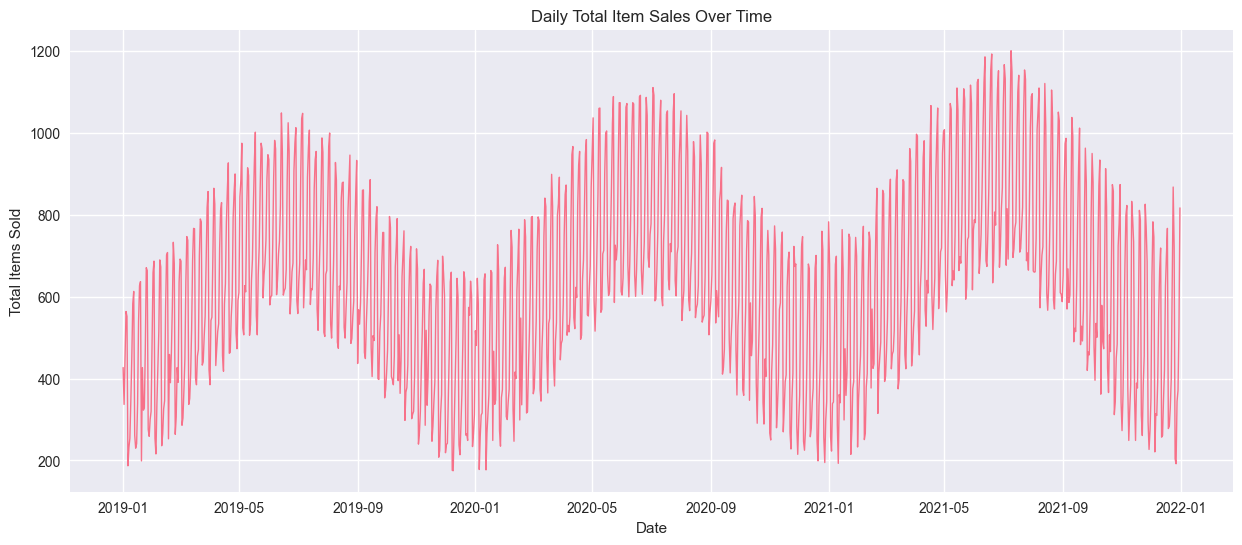

In [26]:
# a. Overall date-wise sales pattern
daily_sales = df.groupby('date')['item_count'].sum().reset_index()

plt.figure(figsize=(15,6))
plt.plot(daily_sales['date'], daily_sales['item_count'], linewidth=1)
plt.title('Daily Total Item Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Items Sold')
plt.show()

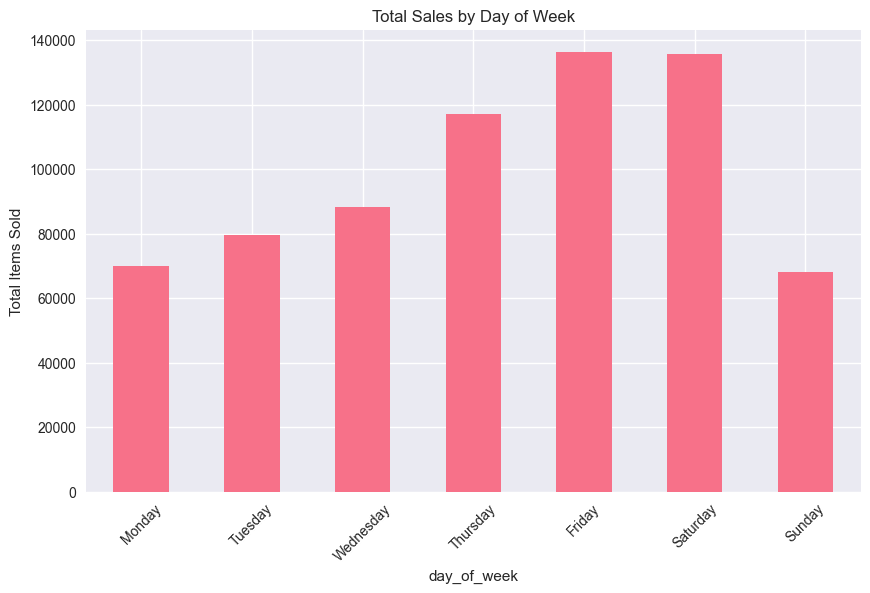

In [27]:
# b. Sales fluctuation across days of the week
dow_sales = df.groupby('day_of_week')['item_count'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10,6))
dow_sales.plot(kind='bar')
plt.title('Total Sales by Day of Week')
plt.ylabel('Total Items Sold')
plt.xticks(rotation=45)
plt.show()

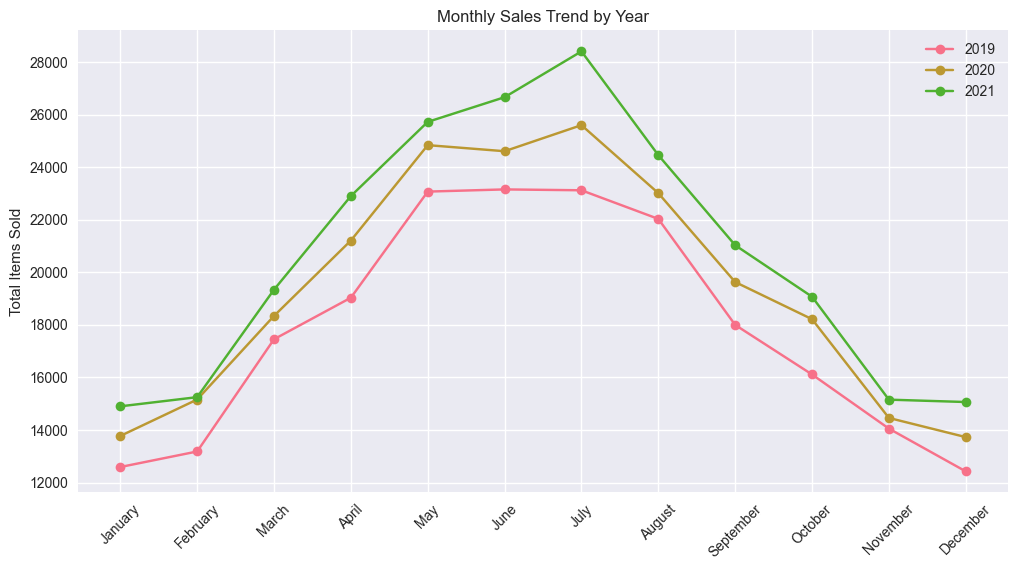

In [28]:
# c. Monthly trends
monthly_sales = df.groupby(['year', 'month_name'])['item_count'].sum().reset_index()
monthly_order = ['January', 'February', 'March', 'April', 'May', 'June',
                 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(12,6))
for year in monthly_sales['year'].unique():
    data = monthly_sales[monthly_sales['year'] == year]
    data = data.set_index('month_name').reindex(monthly_order).reset_index()
    plt.plot(data['month_name'], data['item_count'], marker='o', label=year)
plt.legend()
plt.title('Monthly Sales Trend by Year')
plt.xticks(rotation=45)
plt.ylabel('Total Items Sold')
plt.show()

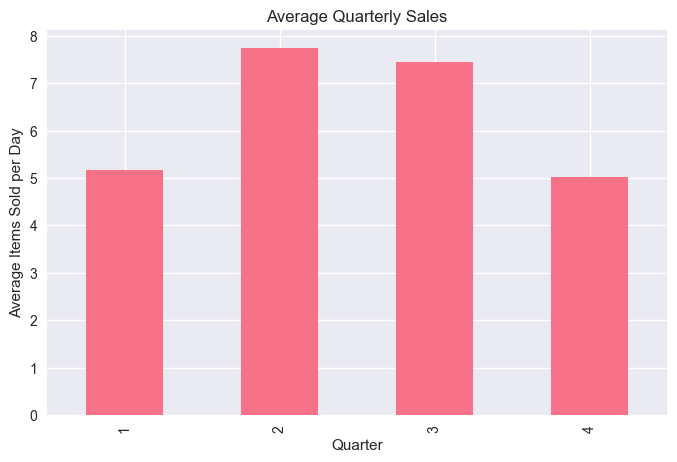

In [29]:
# d. Quarterly sales averaged over years
quarterly = df.groupby('quarter')['item_count'].mean()
plt.figure(figsize=(8,5))
quarterly.plot(kind='bar')
plt.title('Average Quarterly Sales')
plt.xlabel('Quarter')
plt.ylabel('Average Items Sold per Day')
plt.show()


=== Restaurant with Highest Sales Volume ===
       store_name  item_count  sales_amount
1     Bob's Diner    687527.0    6337275.69
4        Surfs Up      1803.0      15651.49
5     Sweet Shack      1736.0       2578.27
2     Corner Cafe      1310.0      16551.43
0  Beachfront Bar      1305.0       3796.20
3        Fou Cher      1106.0      27885.37


<Figure size 1000x600 with 0 Axes>

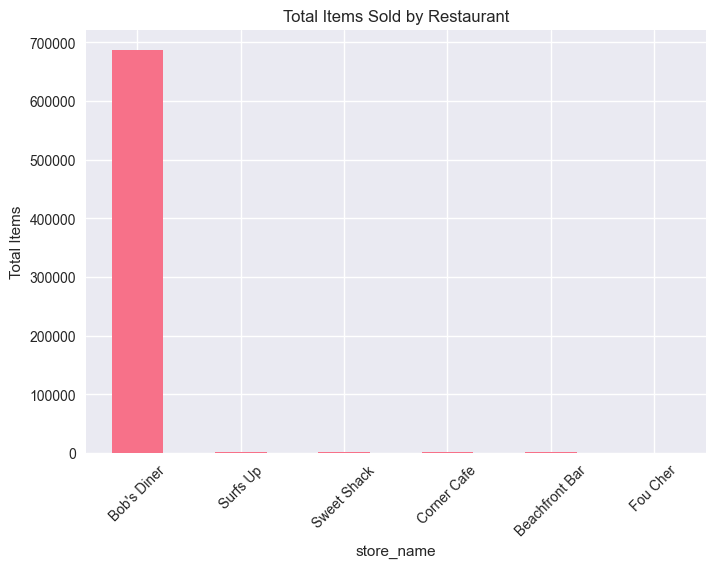

In [ ]:
# e. Restaurant performance comparison.
# Find out which restaurant had the most sales
store_performance = df.groupby('store_name').agg({
    'item_count': 'sum',
    'sales_amount': 'sum'
}).reset_index()

print("\n=== Restaurant with Highest Sales Volume ===")
print(store_performance.sort_values('item_count', ascending=False))

plt.figure(figsize=(10,6))
store_performance.sort_values('item_count', ascending=False).plot(
    x='store_name', y='item_count', kind='bar', legend=False)
plt.title('Total Items Sold by Restaurant')
plt.ylabel('Total Items')
plt.xticks(rotation=45)
plt.show()

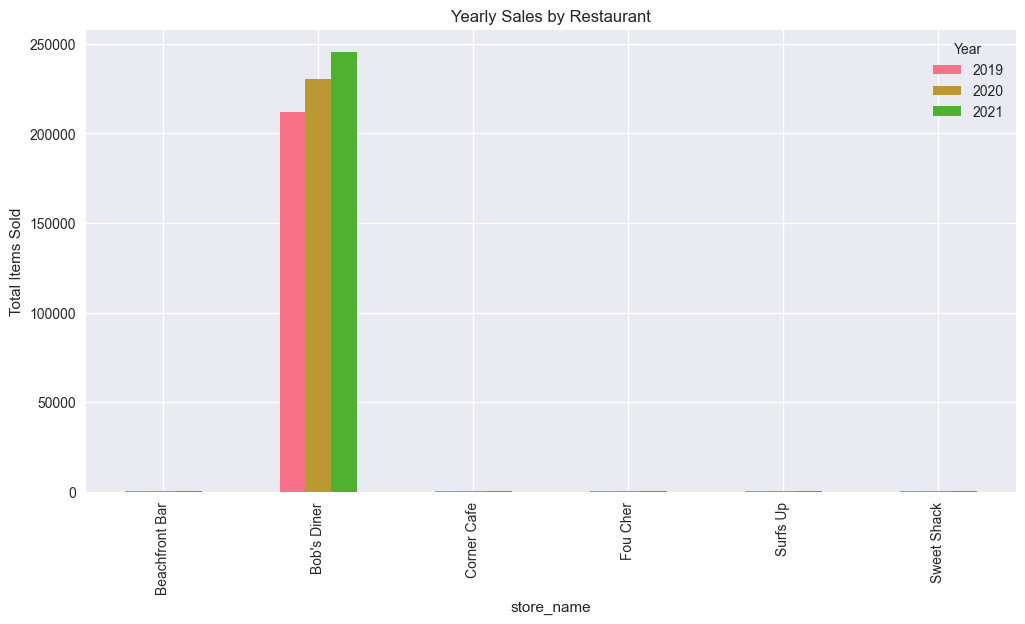

In [ ]:
# Sales for each restaurant across different years
store_year = df.groupby(['store_name', 'year'])['item_count'].sum().unstack()
store_year.plot(kind='bar', figsize=(12,6))
plt.title('Yearly Sales by Restaurant')
plt.ylabel('Total Items Sold')
plt.legend(title='Year')
plt.show()

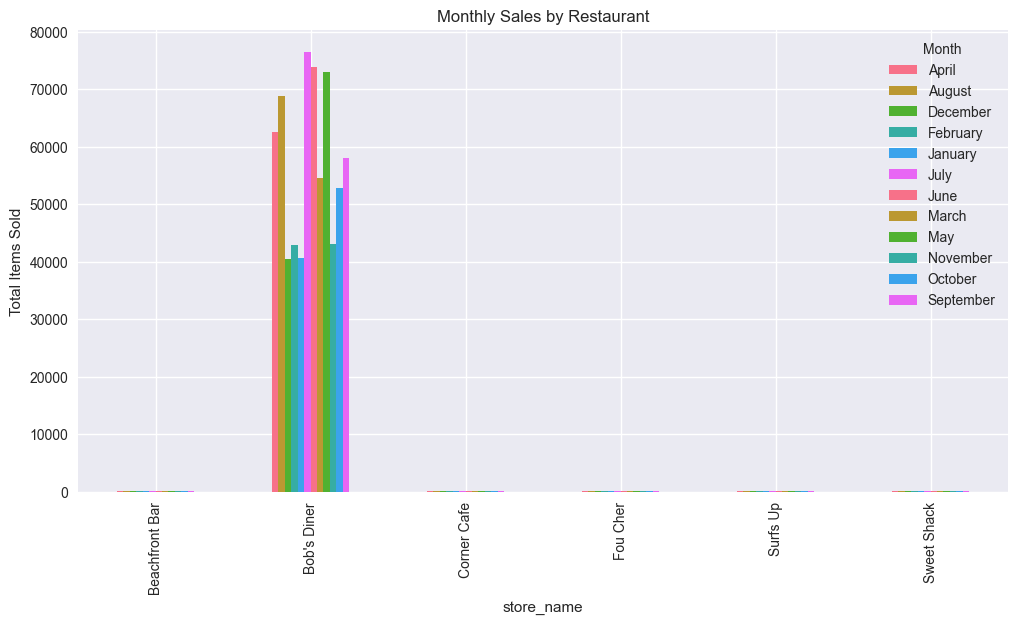

In [ ]:
# Sales for each restaurant across different months.
store_year = df.groupby(['store_name', 'month_name'])['item_count'].sum().unstack()
store_year.plot(kind='bar', figsize=(12,6))
plt.title('Monthly Sales by Restaurant')
plt.ylabel('Total Items Sold')
plt.legend(title='Month')
plt.show()

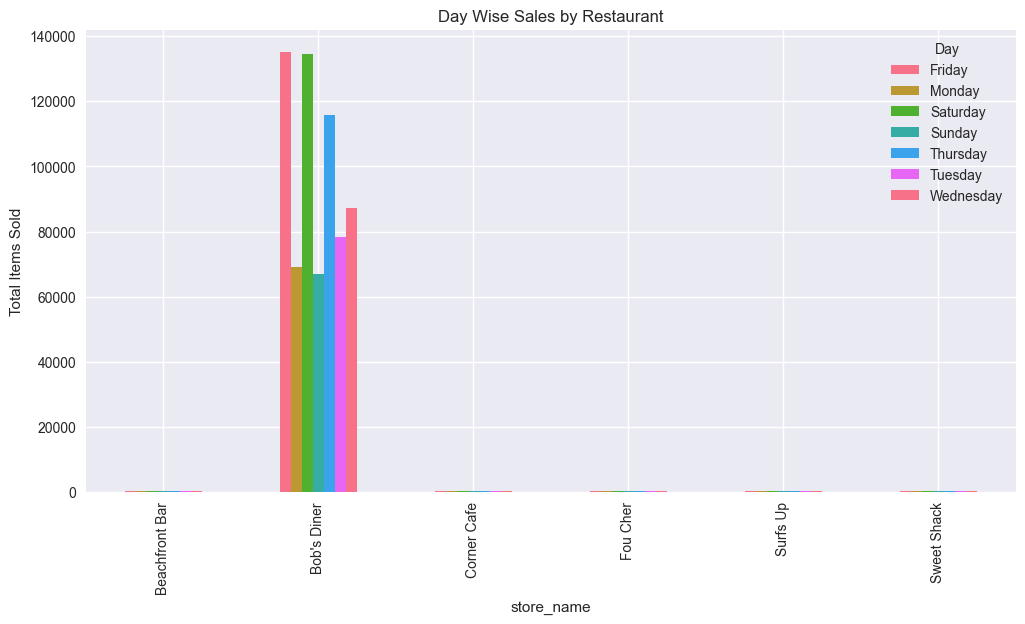

In [33]:
# Sales for each restaurant across different days.
store_year = df.groupby(['store_name', 'day_of_week'])['item_count'].sum().unstack()
store_year.plot(kind='bar', figsize=(12,6))
plt.title('Day Wise Sales by Restaurant')
plt.ylabel('Total Items Sold')
plt.legend(title='Day')
plt.show()


Top 10 Most Popular Items Overall:
item_name
Strawberry Smoothy                 236337.0
Frozen Milky Smoothy               103263.0
Amazing pork lunch                  61043.0
Mutton Dinner                       52772.0
Orange Juice                        43874.0
Blue Ribbon Beef Entree             42774.0
Amazing Steak Dinner with Rolls     34439.0
Sweet Frozen Soft Drink             27490.0
Sea Bass with Vegetables Dinner     23839.0
Sweet Lamb Cake                     18764.0
Name: item_count, dtype: float64


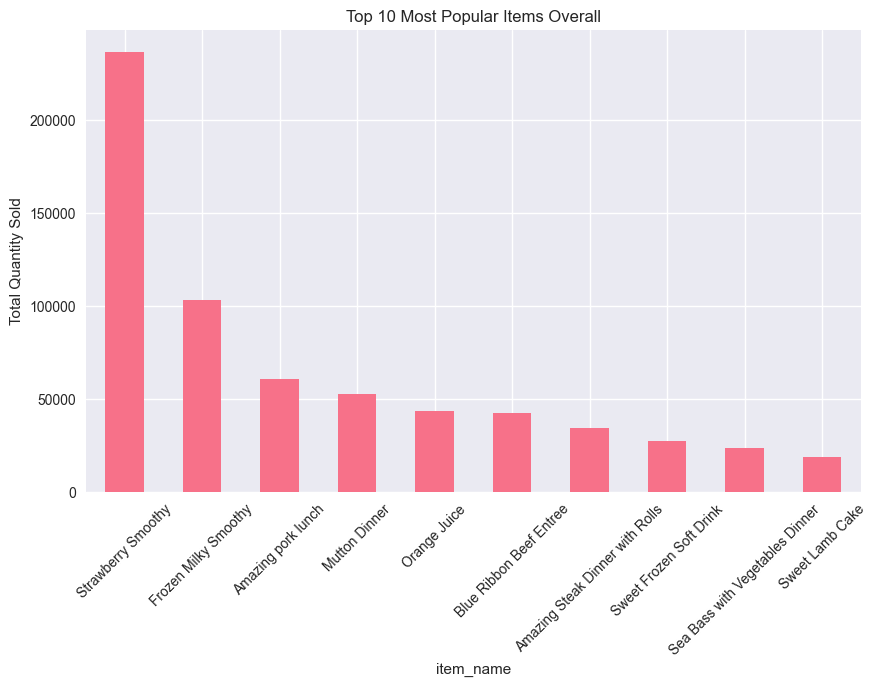

In [35]:
# f. Most popular items overall and per store
overall_popular = df.groupby(['item_name'])['item_count'].sum().sort_values(ascending=False).head(10)
print("\nTop 10 Most Popular Items Overall:")
print(overall_popular)

plt.figure(figsize=(10,6))
overall_popular.plot(kind='bar')
plt.title('Top 10 Most Popular Items Overall')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.show()

In [36]:
# Most popular item at each store
popular_per_store = df.groupby(['store_name', 'item_name'])['item_count'].sum().reset_index()
popular_per_store = popular_per_store.loc[popular_per_store.groupby('store_name')['item_count'].idxmax()]
print("\nMost Popular Item at Each Store:")
print(popular_per_store[['store_name', 'item_name', 'item_count']])


Most Popular Item at Each Store:
        store_name                      item_name  item_count
1   Beachfront Bar        Fantastic Milky Smoothy      1147.0
25     Bob's Diner             Strawberry Smoothy    236337.0
40     Corner Cafe           Frozen Milky Smoothy       273.0
57        Fou Cher  Blue Ribbon Fruity Vegi Lunch       298.0
85        Surfs Up             Awesome Soft Drink       997.0
92     Sweet Shack                Awesome Smoothy      1692.0


In [37]:
# g. Is the store with highest volume also making most money per day?
daily_revenue = df.groupby(['date', 'store_name'])['sales_amount'].sum().reset_index()
avg_daily_revenue = daily_revenue.groupby('store_name')['sales_amount'].mean()

print("\nAverage Daily Revenue per Store:")
print(avg_daily_revenue.sort_values(ascending=False))

print("\nStore with highest volume also highest daily revenue?",
      store_performance.loc[store_performance['item_count'].idxmax(), 'store_name'],
      "->", avg_daily_revenue.idxmax())


Average Daily Revenue per Store:
store_name
Bob's Diner       5782.185849
Fou Cher            25.442856
Corner Cafe         15.101670
Surfs Up            14.280557
Beachfront Bar       3.463686
Sweet Shack          2.352436
Name: sales_amount, dtype: float64

Store with highest volume also highest daily revenue? Bob's Diner -> Bob's Diner


In [39]:
# h. Most expensive item at each restaurant and its calories
expensive_per_store = df.loc[df.groupby('store_name')['cost'].idxmax()][['store_name', 'item_name', 'cost', 'kcal']]
print("\nMost Expensive Item per Restaurant and its Calories:")
print(expensive_per_store)


Most Expensive Item per Restaurant and its Calories:
        store_name                      item_name   cost  kcal
68  Beachfront Bar          Sweet Vegi Soft Drink   5.70   538
0      Bob's Diner              Sweet Fruity Cake  29.22   931
58     Corner Cafe                     Pike Lunch  26.37   653
82        Fou Cher  Blue Ribbon Fruity Vegi Lunch  53.98   881
8         Surfs Up                     Steak Meal  26.21   607
79     Sweet Shack  Blue Ribbon Frozen Milky Cake   7.70   636


# 3. Forecasting using Machine Learning (Linear Reg, RF, XGBoost)

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Prepare aggregated daily total sales for forecasting
daily_total = df.groupby('date').agg({
    'item_count': 'sum'
}).reset_index()

daily_total['year'] = daily_total['date'].dt.year
daily_total['month'] = daily_total['date'].dt.month
daily_total['day'] = daily_total['date'].dt.day
daily_total['day_of_week'] = daily_total['date'].dt.dayofweek
daily_total['quarter'] = daily_total['date'].dt.quarter
daily_total['is_weekend'] = daily_total['day_of_week'].isin([5,6]).astype(int)

In [42]:
# Lag features
for lag in [1,3,7,14,30]:
    daily_total[f'lag_{lag}'] = daily_total['item_count'].shift(lag)

daily_total = daily_total.dropna()

# Features and target
features = ['year','month','day','day_of_week','quarter','is_weekend',
            'lag_1','lag_3','lag_7','lag_14','lag_30']
X = daily_total[features]
y = daily_total['item_count']

In [43]:
# Train-test split: last 6 months as test
max_date = daily_total['date'].max()
six_months_ago = max_date - pd.DateOffset(months=6)

train = daily_total[daily_total['date'] <= six_months_ago]
test = daily_total[daily_total['date'] > six_months_ago]

X_train, X_test = train[features], test[features]
y_train, y_test = train['item_count'], test['item_count']

print(f"Training period: {train['date'].min()} to {train['date'].max()}")
print(f"Testing period : {test['date'].min()} to {test['date'].max()}")

Training period: 2019-01-31 00:00:00 to 2021-06-30 00:00:00
Testing period : 2021-07-01 00:00:00 to 2021-12-31 00:00:00


In [44]:
# Models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    results[name] = rmse
    print(f"{name} RMSE: {rmse:.2f}")

Linear Regression RMSE: 58.79
Random Forest RMSE: 61.99
XGBoost RMSE: 68.60


In [45]:
# Best model
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]
print(f"\nBest performing model: {best_model_name} with RMSE {results[best_model_name]:.2f}")

# Forecast next 365 days using best model
future_dates = pd.date_range(start=max_date + pd.Timedelta(days=1), periods=365)
future = pd.DataFrame({'date': future_dates})

future['year'] = future['date'].dt.year
future['month'] = future['date'].dt.month
future['day'] = future['date'].dt.day
future['day_of_week'] = future['date'].dt.dayofweek
future['quarter'] = future['date'].dt.quarter
future['is_weekend'] = future['day_of_week'].isin([5,6]).astype(int)


Best performing model: Linear Regression with RMSE 58.79


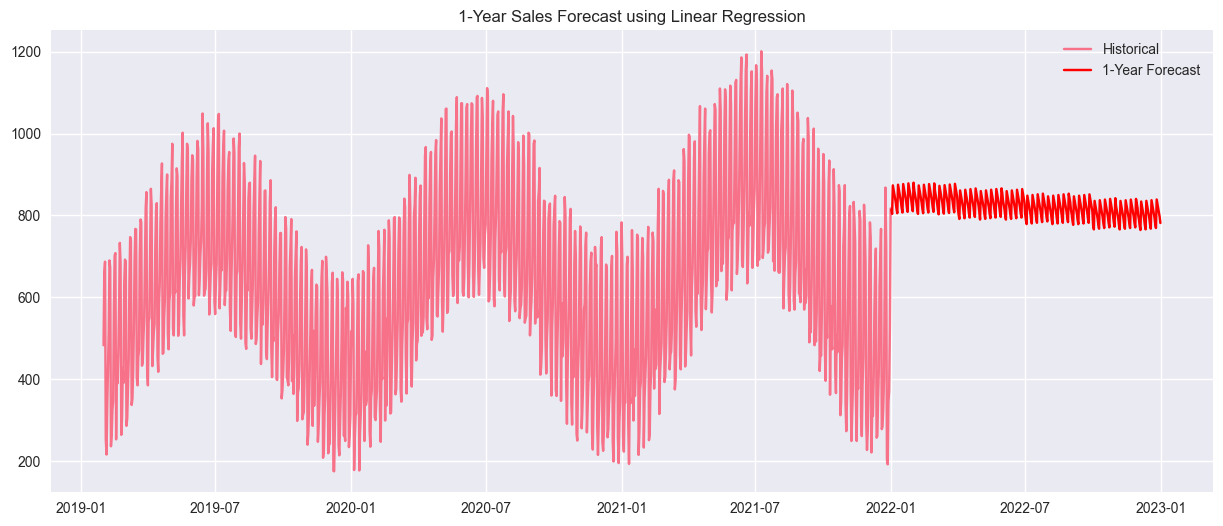

In [46]:
# Use last known lags (simple approximation)
last_row = daily_total.iloc[-1]
for lag in [1,3,7,14,30]:
    future[f'lag_{lag}'] = last_row['item_count']  # placeholder

future_pred = best_model.predict(future[features])

plt.figure(figsize=(15,6))
plt.plot(daily_total['date'], daily_total['item_count'], label='Historical')
plt.plot(future['date'], future_pred, label='1-Year Forecast', color='red')
plt.title(f'1-Year Sales Forecast using {best_model_name}')
plt.legend()
plt.show()

# 4. Forecasting using Deep Learning (LSTM)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
# Use sales amount instead of item count
daily_amount = df.groupby('date')['sales_amount'].sum().reset_index()
daily_amount = daily_amount.set_index('date')

# Scale
scaler = MinMaxScaler()
scaled = scaler.fit_transform(daily_amount)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled, seq_length)

# Train-test split (last 12 months as test for synthetic evaluation)
total_days = len(daily_amount)
test_days = 365
train_size = total_days - test_days

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1)

# Predict on test
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)
actual = scaler.inverse_transform(y_test)

mape = mean_absolute_percentage_error(actual, pred) * 100
print(f"\nLSTM MAPE on last 12 months (synthetic test): {mape:.2f}%")
print("Comment: MAPE < 10% is excellent, < 20% is good, > 30% needs improvement.")

In [ ]:
# Full training for next 3 months forecast
full_model = Sequential()
full_model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
full_model.add(LSTM(50, return_sequences=False))
full_model.add(Dense(25))
full_model.add(Dense(1))
full_model.compile(optimizer='adam', loss='mse')
full_model.fit(X, y, batch_size=32, epochs=20, verbose=1)

In [ ]:
# Forecast next 90 days
last_sequence = scaled[-seq_length:]
future_pred = []

current_seq = last_sequence.copy()
for _ in range(90):
    pred = full_model.predict(current_seq.reshape(1, seq_length, 1), verbose=0)
    future_pred.append(pred[0,0])
    current_seq = np.append(current_seq[1:], pred)

In [ ]:
future_pred = scaler.inverse_transform(np.array(future_pred).reshape(-1,1))
future_dates_90 = pd.date_range(start=daily_amount.index[-1] + pd.Timedelta(days=1), periods=90)

plt.figure(figsize=(12,6))
plt.plot(daily_amount.index[-200:], daily_amount['sales_amount'][-200:], label='Historical')
plt.plot(future_dates_90, future_pred, label='Next 3 Months Forecast', color='green')
plt.title('LSTM Sales Amount Forecast - Next 3 Months')
plt.legend()
plt.show()